/Users/sumsm/Downloads/OilApp/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.stlouisfed.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/sumsm/Downloads/OilApp/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.stlouisfed.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/sumsm/Downloads/OilApp/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.stlouisfed.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings


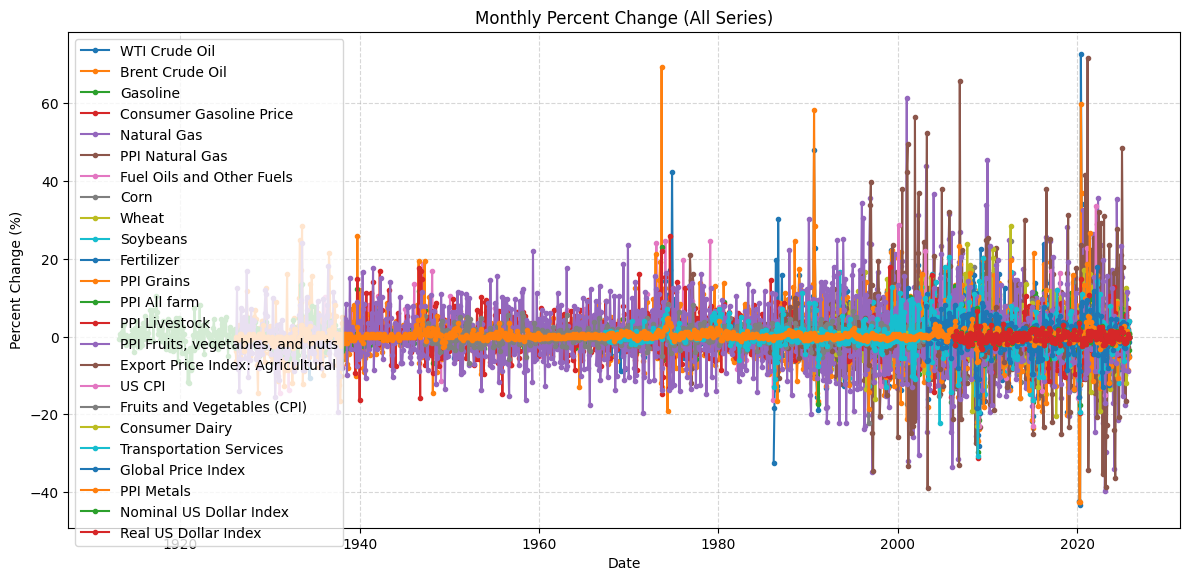

In [ ]:
# imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import xml.etree.ElementTree as ET

# FRED key and request url
API_KEY = '5ca50f6e56fc2f26feb5199f53e3f572'
BASE_URL = 'https://api.stlouisfed.org/fred/series/observations'

# ID to pull from API for each commodity
series_ids = {
    # Energy & Fuels
    "WTI Crude Oil": "DCOILWTICO",
    "Brent Crude Oil": "DCOILBRENTEU",
    "Gasoline": "GASREGM",
    "Consumer Gasoline Price": "CUSR0000SETB01",
    "Natural Gas": "PNGASUSUSDM",
    "PPI Natural Gas": "WPU0531",
    "Fuel Oils and Other Fuels": "DFULRC1A027NBEA",

    # Agriculture & Commodities
    "Corn": "PMAIZMTUSDM",
    "Wheat": "PWHEAMTUSDM",
    "Soybeans": "PSOYBUSDM",
    "Fertilizer": "WPU0652",
    "PPI Grains": "WPU012",
    "PPI All farm": "WPU01",
    "PPI Livestock": "WPU013",
    "PPI Fruits, vegetables, and nuts": "WPU011",
    "Export Price Index: Agricultural": "IQAG",

    # Consumer Prices (CPI Categories)
    "US CPI": "CPIAUCSL",
    "Fruits and Vegetables (CPI)": "CUSR0000SAF113",
    "Consumer Dairy": "CUSR0000SAF111",
    "Transportation Services": "CUSR0000SETB",

    # Macroeconomic & Financial Indices
    "Global Price Index": "PALLFNFINDEXM",
    "PPI Metals": "WPU10",
    "Nominal US Dollar Index": "DTWEXBGS",
    "Real US Dollar Index": "RTWEXBGS"
}


def get_fred_data(series_id, api_key, file_type='xml'):
    #paramters to pass to Api
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': file_type
    }
    # request JSON data from API
    resp = requests.get(BASE_URL, params=params, timeout=15, verify=False)
    resp.raise_for_status()
    root = ET.fromstring(resp.content)
    
    rows = []
    #get all dates and prices
    for obs in root.findall('.//observation'):
        date_str = obs.get('date')
        value_str = obs.get('value')
        # convert missing to NaN
        value = None if value_str in ('.', '', None) else float(value_str)
        rows.append((date_str, value))
    
    # create the series of data
    if not rows:
        return pd.Series(dtype=float, name=series_id)
    # sort data by time
    idx, vals = zip(*rows)
    s = pd.Series(list(vals), index=pd.DatetimeIndex(idx), name=series_id)
    s = s.sort_index()
    return s

# try to get the series for each code using the function made
series_list = {}
for name, code in series_ids.items():
    try:
        series_list[name] = get_fred_data(code, API_KEY)
    except requests.HTTPError as e:
        print(f"Failed: {name} ({code}) — {e}")


# make a dataframe (dataframes make data manipulation easier)
raw_df = pd.DataFrame(series_list)

# use monthly frequencies for all, some come in annual or daily frequencies
monthly_df = raw_df.resample('M').mean()

# restrict to a sensible date range and drop columns with no data at all
monthly_df = monthly_df.dropna(axis=1, how='all')  
monthly_df = monthly_df.sort_index()

# find percent change because actual dollar values provide less insight
pct_change = monthly_df.pct_change() * 100

# drop rows where all data points are NaN
pct_change = pct_change.dropna(how='all')

#plot each series separately
# for col in pct_change.columns:
#     plt.figure(figsize=(11, 5))
#     plt.plot(pct_change.index, pct_change[col], marker='o', linestyle='-', linewidth=1, markersize=4)
#     plt.plot(pct_change.index, pct_change["WTI Crude Oil"], marker='o', linestyle='-', linewidth=1, markersize=4)
#     plt.title(f"Monthly Percent Change: {col}")
#     plt.xlabel("Date")
#     plt.ylabel("Percent Change (%)")
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     plt.show()

# combined lot
plt.figure(figsize=(12, 6))
for col in pct_change.columns:

    plt.plot(pct_change.index, pct_change[col], marker='o', linestyle='-', markersize=3, label=col)
plt.title("Monthly Percent Change (All Series)")
plt.xlabel("Date")
plt.ylabel("Percent Change (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# save to csv
monthly_df.to_csv("commodities_monthly_values.csv")
pct_change.to_csv("commodities_monthly_pct_change.csv")


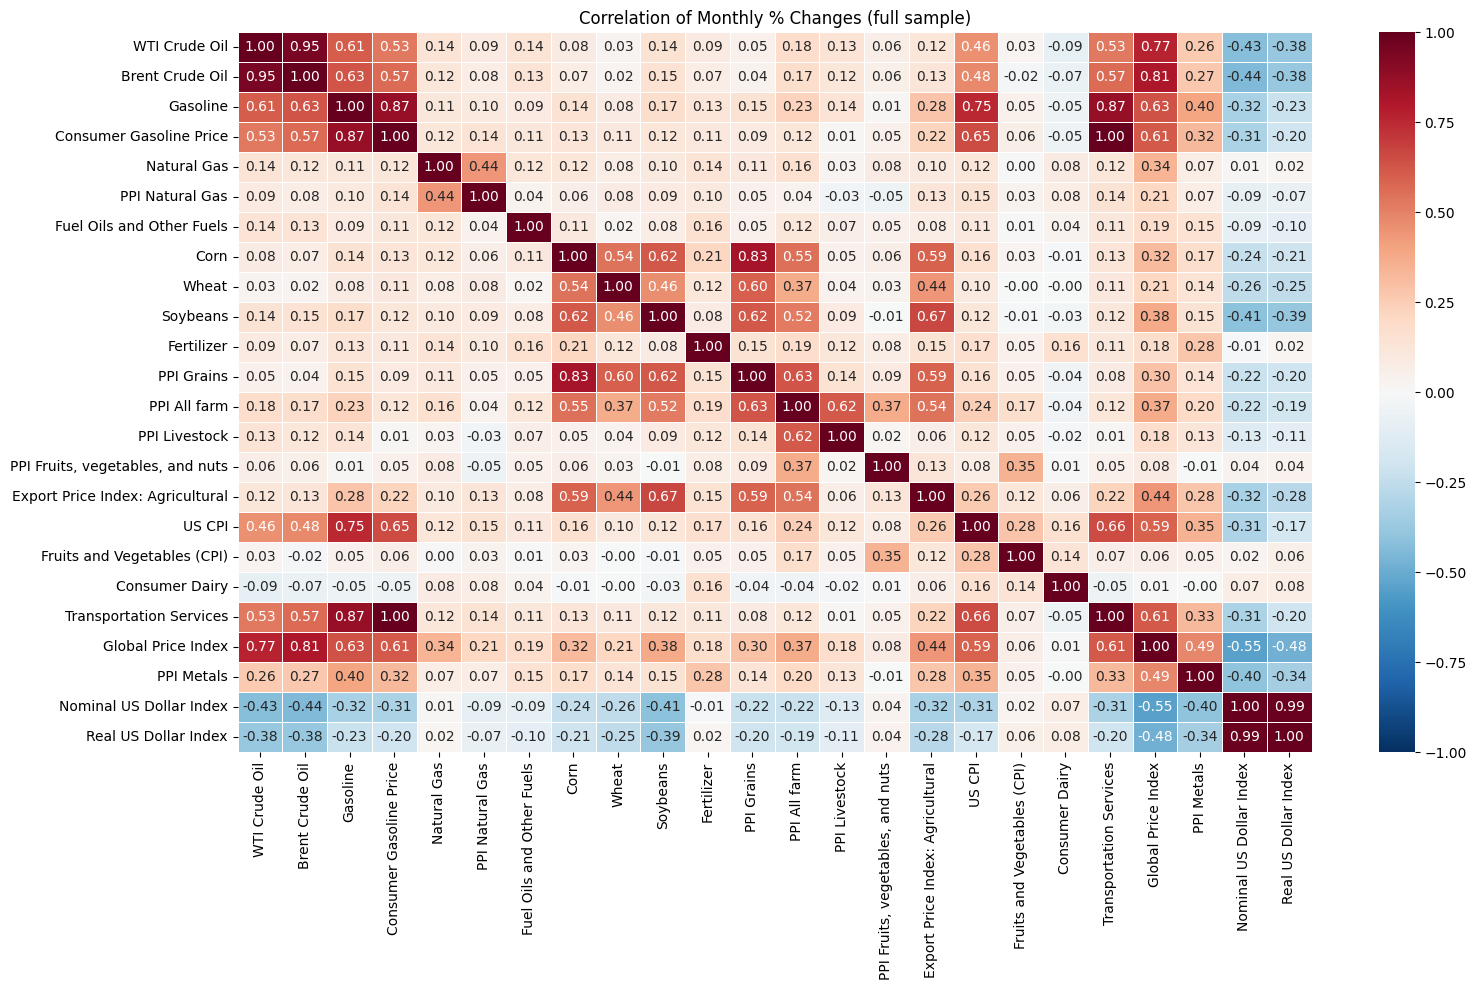

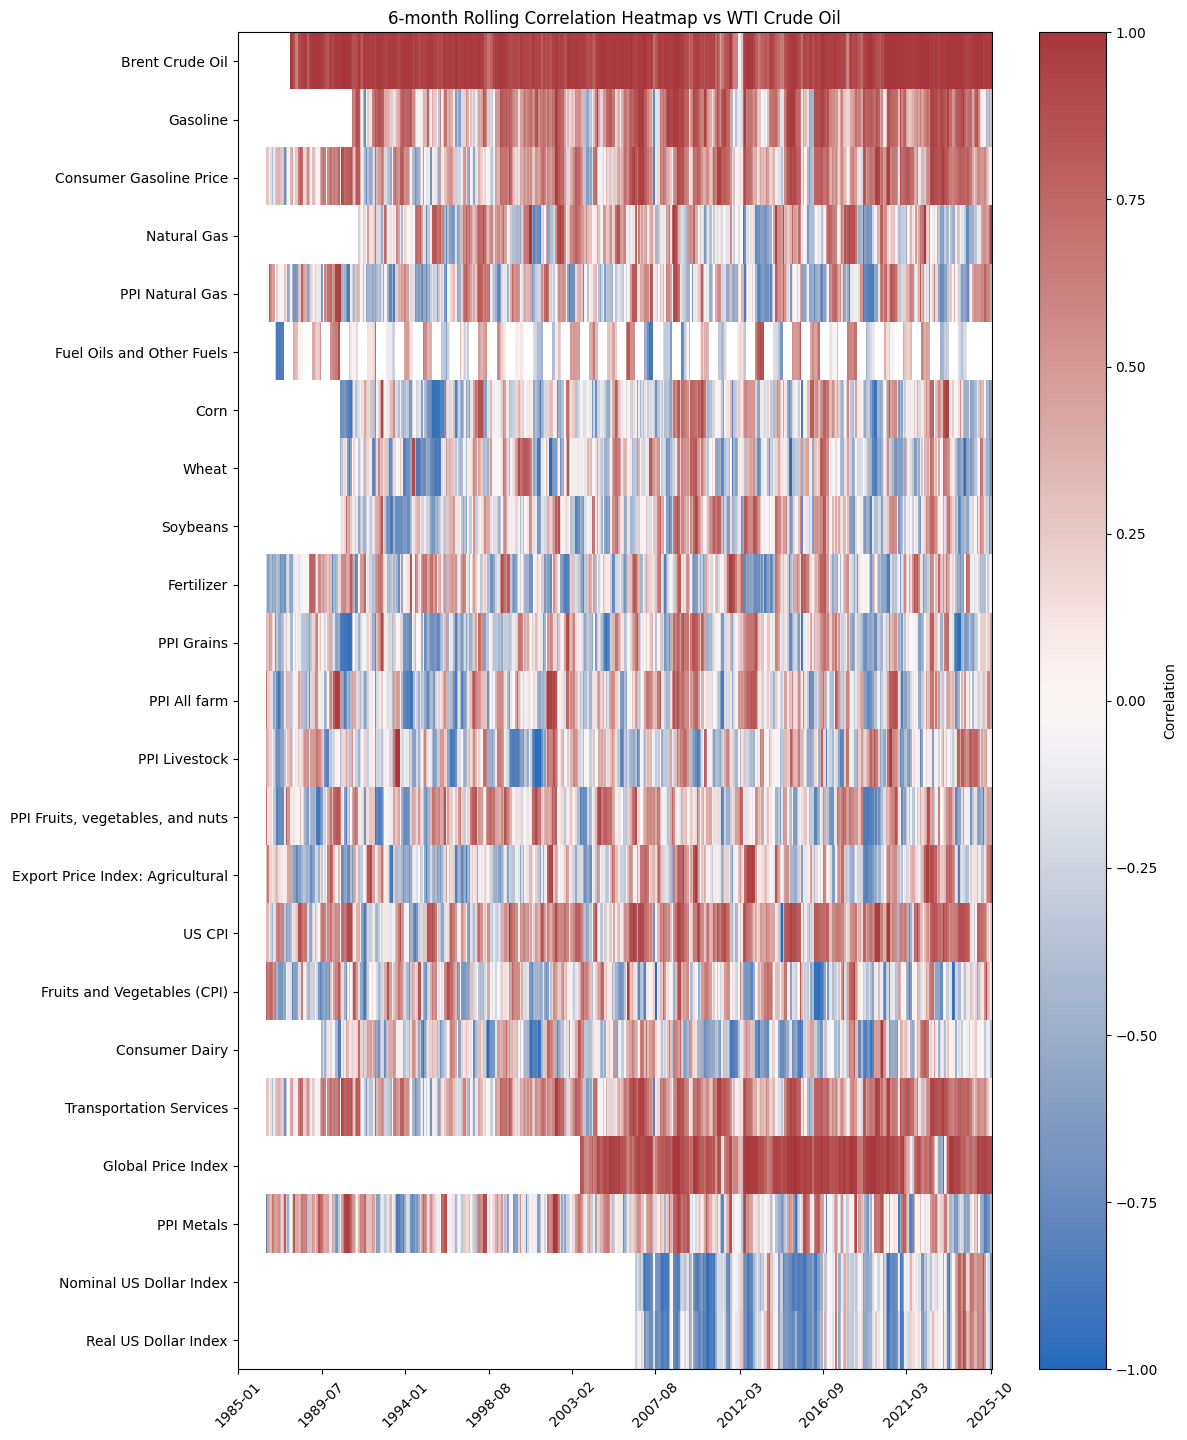

In [ ]:
import seaborn as sns
import numpy as np

#heat map
corr = pct_change.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",    # diverging colormap, red is positive relation, blue is inverse
    center=0,         # ensures 0 = white
    linewidths=.5,
    vmin=-1, vmax=1   # fix scale
)
plt.title("Correlation of Monthly % Changes (full sample)")
plt.tight_layout()
plt.show()


window = 6  # months
base = 'WTI Crude Oil'  

rolling_pairs = {}
for col in pct_change.columns:
    if col == base:
        continue
    rolling_pairs[col] = pct_change[base].rolling(window).corr(pct_change[col])

rolling_df = pd.DataFrame(rolling_pairs)

# rolling correlation heatmap, shows the relationship over time rather than as a whole.
rolling_matrix = rolling_df.T.copy()
rolling_matrix.columns = pd.to_datetime(rolling_matrix.columns)
# start from 1985 and onward as there's a lot of empty data before that
start = pd.Timestamp("1985-01-01")
rolling_matrix_filtered = rolling_matrix.loc[:, rolling_matrix.columns >= start]

# ensure there's data after filtering
if rolling_matrix_filtered.shape[1] == 0:
    raise ValueError("help, no columns")

plt.figure(figsize=(12, 3 + 0.5 * rolling_matrix_filtered.shape[0]))
plt.imshow(rolling_matrix_filtered, aspect='auto', interpolation='nearest', cmap='vlag', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.yticks(np.arange(len(rolling_matrix_filtered.index)), rolling_matrix_filtered.index)

# xticks: pick 10 evenly spaced dates
xtick_idx = np.linspace(0, rolling_matrix_filtered.shape[1]-1, 10, dtype=int)
plt.xticks(
    xtick_idx,
    [rolling_matrix_filtered.columns[i].strftime("%Y-%m") for i in xtick_idx],
    rotation=45
)
plt.title(f"{window}-month Rolling Correlation Heatmap vs {base}")
plt.tight_layout()
plt.show()
